## Library imports

In [42]:
#standard libraries

import random
import os
import numpy as np
import time
import copy

from matplotlib.colors import ListedColormap # colormaps
import matplotlib.pyplot as plt # visualizations
%matplotlib inline


#Pytorch
import torch #operations in tensors
from torch import nn #layer package and activation functions
from torch import optim # optimization package
from torch.optim import lr_scheduler #scheduler package
import torchvision
from torchvision.models import resnet18, ResNet18_Weights #pre-trained architectures


#Data Set
from torch.utils import data #create new datasets or iterate over one already created
from torchvision import datasets #preloaded datasets
from torchvision import transforms #transformations on the data after it is loaded


#pre-trained models
from torchvision import models #load different pre-trained models

from tqdm.auto import tqdm
from prettytable import PrettyTable
from trainer import Trainer
from callbacks import ModelCheckpoint, EarlyStopping

try:
  import torchinfo
except:
  !pip install torchinfo
from torchinfo import summary # Information of implemented architectures



In [30]:
#!pip install torchinfo

In [2]:
#pip install --user matplotlib
#pip install --user --upgrade matplotlib

In [3]:
#pip install torch

In [4]:
#pip install torchvision

## Seeds for Reproductibility

In [5]:
def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.benchmark = False
    #torch.backends.cudnn.deterministic = True
  
  print(f'Seed {seed} has been assigned.')

In [6]:
set_seed(42)

Seed 42 has been assigned.


## Device
We select the available device to perform the training and tests.

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('Using {}'.format(device))

Using cpu


## Useful functions

### Method to visualize learning curves

In [8]:
def visualize_learning_curves(results):
    fig = plt.figure(figsize=(15,5))
    ax = plt.subplot(121)
    epochs = range(1, len(results["train_loss"])+1)
    plt.plot(epochs, results["train_loss"])
    plt.plot(epochs,results["val_loss"])
    plt.title("Loss vs epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["train", "val"])

    ax = plt.subplot(122)
    plt.plot(epochs, results["train_acc"])
    plt.plot(epochs, results["val_acc"])
    plt.title("ACC vs epoch")
    plt.xlabel("Epochs")
    plt.ylabel("ACC")
    plt.legend(["train", "val"])
    plt.show()

### Summary of Results

In [9]:
def print_table(headers, values):
    table = PrettyTable(headers)
    for i in values:
        table.add_row(i)
    table.float_format = '.3'    
    print(table)

def add_results(name, ckp_results):
    return [name, ckp_results['train_loss'], ckp_results['val_loss'], 
                  ckp_results['train_acc'], ckp_results['val_acc'] ]

def total_num_parameters(model):
    return sum(p.numel() for p in model.parameters())

## Dataset

Download  from : https://download.pytorch.org/tutorial/hymenoptera_data.zip , and extract it to the current directory. In colab we can use !wget to download it and !unzip to extract it:



In [10]:
#!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
#!unzip hymenoptera_data.zip

In [11]:
# import urllib.request

# url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
# file_name = 'hymenoptera_data.zip'

# urllib.request.urlretrieve(url, file_name)

In [12]:
# import zipfile

# zip_file = 'hymenoptera_data.zip'
# with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#     zip_ref.extractall()

## Image visualization

In [13]:
from PIL import Image

def visualize_images(directory, title="", num_images=4):
    # Get the file paths of all images in the directory
    image_paths = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            image_paths.append(os.path.join(directory, filename))

    # Sample image paths
    random.sample(image_paths, num_images)
    # Shuffle the image paths randomly
    #random.shuffle(image_paths)

    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

    # Load and display images
    for i in range(num_images):
        image = Image.open(image_paths[i])
        axes[i].imshow(image)
        axes[i].set_yticks([])
        axes[i].set_xticks([])        
        axes[i].set_xlabel(f"Shape: {image.size}")

    # Adjust spacing between subplots
    plt.tight_layout()
    # Set title
    plt.title(title)
    # Display the plot
    plt.show()

In [17]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#  OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized refers to an issue with OpenMP, which is a library used for parallel programming.



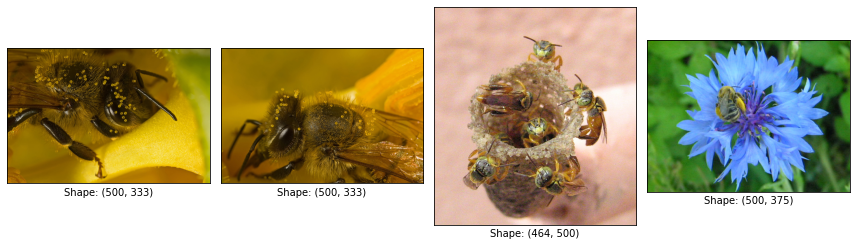

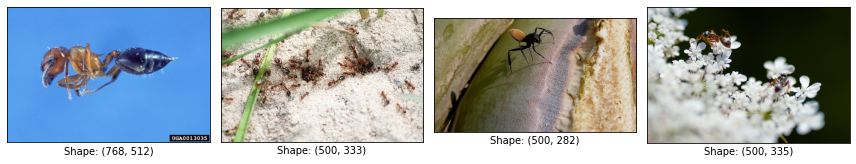

In [18]:
# Directory containing the images
train_dir = "hymenoptera_data/train"
bees_directory = os.path.join(train_dir, "bees")
ants_directory = os.path.join(train_dir, "ants")

# Visualize images
visualize_images(bees_directory, num_images=4)
visualize_images(ants_directory, num_images=4)

## Mean and std per channel

In [19]:
# Mean and standard deviation of imagenet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

## Loading the dataset

In [20]:
# Training data
train_transform = transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ])

# Validation data
val_transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ])

Now we will load the dataset, previously downloaded, using [ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html). 

In [21]:
# Directory where the data is located
data_dir = 'hymenoptera_data'

# Load the training dataset using ImageFolder
train_ds = datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform)

# Load the validation dataset using ImageFolder
val_ds = datasets.ImageFolder(os.path.join(data_dir, 'val'), val_transform)

*Let*'s print some information

In [22]:
# Classnames
class_names = train_ds.classes
NUM_CLASSES = len(class_names)

print('Dataset sizes')
print(f'Train size: {len(train_ds)}')
print(f'Validation size: {len(val_ds)}')

print('\nClasses')
print(class_names)

Dataset sizes
Train size: 244
Validation size: 153

Classes
['ants', 'bees']



### Creation of dataloaders


In [25]:
# TODO: Create DataLoader for training data, use 32 samples per batch
train_dl = data.DataLoader(train_ds, batch_size=32, shuffle=True)

# TODO: create DataLoader for validation data, use 32 samples per batch
val_dl = data.DataLoader(val_ds, batch_size=32, shuffle=False)



## Visualization

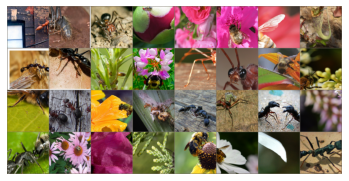

In [26]:
def imshow(img, title=None):
    """Imshow for tensors"""
    # We will use numpy to ease the process
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(IMAGENET_MEAN)
    std = np.array(IMAGENET_STD)
    # Denormalization
    img = std * img + mean
    # Make sure that the pixel values are between 0 and 1
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")
    if title is not None:
        plt.title(title)

# Get a random training batch
X_batch, y_batch = next(iter(train_dl))

# Create a grid for visualization
out = torchvision.utils.make_grid(X_batch)

# Display the grid of images
imshow(out)

## Training from scratch

In [34]:
from torchvision.models import resnet18
from torchinfo import summary
resnet = resnet18()

In [35]:
summary(resnet, input_size=(32, 3, 224, 224), col_names=('input_size', 'output_size', 'num_params') )

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [32, 3, 224, 224]         [32, 1000]                --
├─Conv2d: 1-1                            [32, 3, 224, 224]         [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 112, 112]        [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3     

In [36]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
#resnet.layer2
resnet.layer2[0]

BasicBlock(
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downsample): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [41]:
resnet.fc.out_features =2
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
ckp = ModelCheckpoint('resnet18_from_scratch.pt', mode='min', monitor='val_loss', verbose=False)
early_stopping = EarlyStopping(mode='min', monitor='val_loss', patience=3)

# Hyperparameters
num_epochs = 10
learning_rate = 1e-5

optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)

trainer = Trainer(ckp, early_stopping)

baseline_results = trainer.train(train_dl, val_dl, resnet, num_epochs, optimizer, device)

Epoch 10/10: 100%|██████████| 8/8 [00:26<00:00,  3.37s/it, train_loss=5.11, val_loss=5.06, train_acc=0.598, val_acc=0.575]


### Learning curves

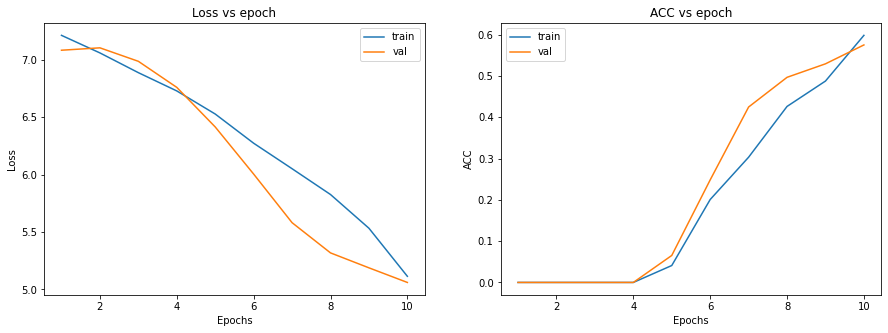

In [45]:
visualize_learning_curves(baseline_results)

In [46]:
resnet_ckp_results = ckp.best_results
print_table(["Network", "Train Loss", "Val Loss", "Train Accuracy", "Val Accuracy"], [ \
            add_results('Baseline', resnet_ckp_results)
           ])

+----------+------------+----------+----------------+--------------+
| Network  | Train Loss | Val Loss | Train Accuracy | Val Accuracy |
+----------+------------+----------+----------------+--------------+
| Baseline |   5.114    |  5.060   |     0.598      |    0.575     |
+----------+------------+----------+----------------+--------------+


### Feature extraction

In [47]:
from torchvision.models import resnet18, ResNet18_Weights # pre-trained architectures

weights = ResNet18_Weights.DEFAULT #ResNet18_Weights.IMAGENET1K_V1

resnet_model = resnet18(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\cajue/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:05<00:00, 8.70MB/s]


In [48]:
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [56]:
resnet_model = torch.nn.Sequential(*list(resnet_model.children())[:-1])
resnet_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

#### Example

In [62]:
X_batch, y_batch = next(iter(train_dl))

resnet_model.eval()

with torch.no_grad():
    features = resnet_model(X_batch)

print(features.shape)

torch.Size([32, 128, 28, 28])


In [63]:
features = features.squeeze()
print(f'Input size: {X_batch.shape}')
print(f'Features size: {features.shape}')

Input size: torch.Size([32, 3, 224, 224])
Features size: torch.Size([32, 128, 28, 28])


In [64]:
#For training
def feature_extraction(model, dl):
    # TODO:
    model.eval()
    features_list = []
    labels_list = []

    with torch.no_grad():
        for X_batch, y_batch in dl:
            features = model(X_batch)
            features = features.numpy()
            labels = y_batch.numpy()

            features_list.append(features)
            labels_list.append(labels)

    features = np.vstack(features_list)
    labels = np.concatenate(labels_list)

    return np.squeeze(features), np.squeeze(labels) #numpy features->[num_samples, 512], labels->[num_samples]

In [65]:
train_features, train_labels = feature_extraction(resnet_model, train_dl)
val_features, val_labels = feature_extraction(resnet_model, val_dl)

print(f'Train features: {train_features.shape}')
print(f'Validation features: {val_features.shape}')

Train features: (244, 128, 28, 28)
Validation features: (153, 128, 28, 28)


## Classify with SVM

In [69]:
# # Classify this new data with SVM
# from sklearn.svm import SVC

# svm = SVC()
# # Reshape train_features to have two dimensions
# num_samples = train_features.shape[0]
# num_features = np.prod(train_features.shape[1:])
# train_features = train_features.reshape(num_samples, num_features)


# # Reshape val_features to have two dimensions
# num_samples_val = val_features.shape[0]
# num_features_val = np.prod(val_features.shape[1:])
# val_features = val_features.reshape(num_samples_val, num_features_val)



# # Train the SVM classifier
# svm.fit(train_features, train_labels)

# #svm.fit(train_features, train_labels)

# y_train_pred = svm.predict(train_features)
# y_val_pred = svm.predict(val_features)

# train_acc = np.mean(y_train_pred == train_labels)
# val_acc = np.mean(y_val_pred == val_labels)

# print(f'Train accuracy: {train_acc:.3f}')
# print(f'Validation accuracy: {val_acc:.3f}')

Train accuracy: 0.992
Validation accuracy: 0.752


In [73]:
# Classify this new data with SVM
from sklearn.svm import SVC

svm = SVC()

svm.fit(train_features, train_labels)

y_train_pred = svm.predict(train_features)
y_val_pred = svm.predict(val_features)

train_acc = np.mean(y_train_pred == train_labels)
val_acc = np.mean(y_val_pred == val_labels)

print(f'Train accuracy: {train_acc:.3f}')
print(f'Validation accuracy: {val_acc:.3f}')

Train accuracy: 0.992
Validation accuracy: 0.752


### Summary of results

In [70]:
resnet_ckp_results = ckp.best_results
print_table(["Network", "Train Loss", "Val Loss", "Train Accuracy", "Val Accuracy"], [ \
            add_results('Baseline', resnet_ckp_results),
            ['SVM', '-', '-', train_acc, val_acc]
           ])

+----------+------------+----------+----------------+--------------+
| Network  | Train Loss | Val Loss | Train Accuracy | Val Accuracy |
+----------+------------+----------+----------------+--------------+
| Baseline |   5.114    |  5.060   |     0.598      |    0.575     |
|   SVM    |     -      |    -     |     0.992      |    0.752     |
+----------+------------+----------+----------------+--------------+


## Fine tunning

In [71]:
weights = ResNet18_Weights.DEFAULT
resnet_model = resnet18(weights=weights)
in_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(in_features, 2) 

In [72]:
ckp = ModelCheckpoint('resnet18_finetuning.pt', mode='min', monitor='val_loss', verbose=False)
early_stopping = EarlyStopping(mode='min', monitor='val_loss', patience=3)

# Hyperparameters
num_epochs = 10
learning_rate = 1e-5

optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)

trainer = Trainer(ckp, early_stopping)

finetuning_results = trainer.train(train_dl, val_dl, resnet_model, num_epochs, optimizer, device)

Epoch 10/10: 100%|██████████| 8/8 [00:25<00:00,  3.16s/it, train_loss=0.215, val_loss=0.234, train_acc=0.934, val_acc=0.915]
